In [1]:
import soundfile as sf
import pandas as pd
import numpy as np
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor
from jiwer import wer, cer

# Baseline Model and Results

In [2]:
# Load the pre-trained model
baseline_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You sho

In [3]:
def transcribe_audio(model, processor, audio_file):
    # Load audio
    speech, sr = sf.read(audio_file)
    
    # Process audio
    input_values = processor(speech, sampling_rate= sr, return_tensors="pt", padding=True).input_values

    # Get model's predictions
    logits = model(input_values).logits

    # Decode the logits to text
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])

    return transcription

In [4]:
# Use this function to transcribe an audio file
# Paths to your folders
test_paths = pd.read_csv('test_data.csv', sep=';')
test_paths = test_paths[["audio_save","expression"]]

all_wer = []
all_cer = []

results = pd.DataFrame(columns=["actual_transcript","model_transcript","wer","cer"])

# Iterate over all files
for i in range(0, len(test_paths)):
    # Full paths to the files
    audio_path = test_paths["audio_save"][i]
    actual_transcript = test_paths["expression"][i]

    # Transcribe the audio file
    predicted_transcript = transcribe_audio(baseline_model, processor, audio_path)

    # Compute the WER
    werr_error = wer(actual_transcript, predicted_transcript)
    cerr_error = cer(actual_transcript, predicted_transcript)
    all_wer.append(werr_error)
    all_cer.append(cerr_error)
    new_row = [actual_transcript, predicted_transcript, werr_error,cerr_error]
    results.loc[len(results)] = new_row

In [5]:
# Compute the mean WER
mean_wer = np.mean(all_wer)
min_wer = np.min(all_wer)
max_wer = np.max(all_wer)
mean_cer = np.mean(all_cer)
# Print the mean WER
print(f"Mean WER: {mean_wer}")
print(f"Min WER: {min_wer}")
print(f"Max WER: {max_wer}")
print(f"Mean CER: {mean_cer}")

Mean WER: 0.8888715153285706
Min WER: 0.0
Max WER: 3.0
Mean CER: 0.7181515836955346


In [6]:
#show 10 random samples from results dataframe
results.sample(10)

,actual_transcript,model_transcript,wer,cer
21,AND HERE IS STANDING A HOUSE,IDEA SPANDING AT HA,1.000000,0.535714
297,BOX,BOX,0.000000,0.000000
107,HELLO MY NAME IS CARSTEN,SO MY NAME IS CUSTOM,0.400000,0.333333
158,I SEE ARROWS,SEE ARROWS,0.333333,0.166667
236,NO,HER,1.000000,1.500000
126,I SEE A WINDOW,I SEE AND WINGDOM,0.500000,0.285714
207,EH A BOY IS,AND A BY ES,0.750000,0.454545
147,AND WATER,IN IN GOOD ORDER,2.000000,1.222222
305,ORANGE,ORANGE,0.000000,0.000000
117,AND,,1.000000,1.000000


# Fine Tuning

## Prepare Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
dataset = pd.read_csv("data.csv", sep=";")

In [9]:
dataset.head()

,id,speaker_id,audio_save,transcript_save,expression
0,1,0,audio_saves\1.wav,transcript_saves\1.txt,YEAH
1,2,0,audio_saves\2.wav,transcript_saves\2.txt,SNOWDROPS I LIKE TO THINK THAT LONG AGO THERE ...
2,3,1,audio_saves\3.wav,transcript_saves\3.txt,WHICH LOVED THIS COLD GRAY WORLD OF OURS SO MU...
3,4,1,audio_saves\4.wav,transcript_saves\4.txt,YEAH
4,5,1,audio_saves\5.wav,transcript_saves\5.txt,THE EMPERORS NEW CLOTHES


In [10]:
# Get the unique speaker IDs
unique_speakers = dataset['speaker_id'].unique()

# Split the speaker IDs into train and test sets
train_speakers, test_speakers = train_test_split(unique_speakers, test_size=0.2, shuffle=True, random_state=11)

# Create train and test datasrames based on the speaker IDs
train_df = dataset[dataset['speaker_id'].isin(train_speakers)]
test_df = dataset[dataset['speaker_id'].isin(test_speakers)]

In [11]:
train_df

,id,speaker_id,audio_save,transcript_save,expression
0,1,0,audio_saves\1.wav,transcript_saves\1.txt,YEAH
1,2,0,audio_saves\2.wav,transcript_saves\2.txt,SNOWDROPS I LIKE TO THINK THAT LONG AGO THERE ...
2,3,1,audio_saves\3.wav,transcript_saves\3.txt,WHICH LOVED THIS COLD GRAY WORLD OF OURS SO MU...
3,4,1,audio_saves\4.wav,transcript_saves\4.txt,YEAH
4,5,1,audio_saves\5.wav,transcript_saves\5.txt,THE EMPERORS NEW CLOTHES
...,...,...,...,...,...
1535,1688,36,audio_saves\1688.wav,transcript_saves\1688.txt,YES
1538,1691,36,audio_saves\1691.wav,transcript_saves\1691.txt,YES
1541,1696,36,audio_saves\1696.wav,transcript_saves\1696.txt,TABLE
1543,1698,36,audio_saves\1698.wav,transcript_saves\1698.txt,MY RAT IS ON THE WAND


In [12]:
test_df

,id,speaker_id,audio_save,transcript_save,expression
424,452,9,audio_saves\452.wav,transcript_saves\452.txt,YES
426,454,9,audio_saves\454.wav,transcript_saves\454.txt,YES
427,455,9,audio_saves\455.wav,transcript_saves\455.txt,EH
429,457,9,audio_saves\457.wav,transcript_saves\457.txt,YES
431,459,9,audio_saves\459.wav,transcript_saves\459.txt,NO
...,...,...,...,...,...
1536,1689,37,audio_saves\1689.wav,transcript_saves\1689.txt,YES
1537,1690,37,audio_saves\1690.wav,transcript_saves\1690.txt,HM
1539,1692,37,audio_saves\1692.wav,transcript_saves\1692.txt,YEAH
1540,1693,37,audio_saves\1693.wav,transcript_saves\1693.txt,MY RAT IS IN THE <unk>


In [13]:
unique_speakers_train = train_df['speaker_id'].unique()
print(unique_speakers_train)
unique_speakers_test = test_df['speaker_id'].unique()
print(unique_speakers_test)


[ 0  1  2  3  4  5  6  7  8 10 11 13 12 14 17 16 18 19 20 23 22 25 24 26
 31 30 32 33 35 36]
[ 9 15 21 27 28 29 34 37]


In [14]:
train_df.to_csv("train_data.csv", index=False, sep=";")
test_df.to_csv("test_data.csv", index=False, sep=";")

## Training & Evaluation

In [15]:
from datasets import DatasetDict, Dataset

In [16]:
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-base-960h")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You sho

### Generate the inputs

In [17]:
df1 = pd.DataFrame(columns=['input_values', 'input_length', 'labels'])
for index, row in train_df.iterrows():
    if row["id"] == "id": continue
    speech, sr = sf.read(row['audio_save'])
    #sppeech = processor(speech, sampling_rate=sr).input_values
    data = {'input_values': speech.tolist(), 'input_length': len(speech), 'labels': tokenizer(row['expression']).input_ids}
    new_df = pd.DataFrame([data])
    df1 = pd.concat([df1, new_df])

In [18]:
df2 = pd.DataFrame(columns=['input_values', 'input_length', 'labels'])
for index, row in test_df.iterrows():
    if row["id"] == "id": continue
    speech, sr = sf.read(row['audio_save'])
    #sppeech = processor(speech, sampling_rate= sr).input_values
    data = {'input_values': speech.tolist(), 'input_length': len(speech), 'labels': tokenizer(row['expression']).input_ids}
    new_df = pd.DataFrame([data])
    df2 = pd.concat([df2, new_df])

In [19]:
raw_dataset = DatasetDict()

In [20]:
#df1=pd.read_json("train_inputs.json", lines=True)
raw_dataset["train"] = Dataset.from_pandas(df1.reset_index(drop=True))


In [21]:
#df2 = pd.read_json("test_inputs.json", lines=True)
raw_dataset["test"] = Dataset.from_pandas(df2.reset_index(drop=True))

In [22]:
print(raw_dataset["train"])
print(raw_dataset["test"])

Dataset({
    features: ['input_values', 'input_length', 'labels'],
    num_rows: 1219
})
Dataset({
    features: ['input_values', 'input_length', 'labels'],
    num_rows: 326
})


### Set-up Trainer


In [23]:
import evaluate
wer_metric = evaluate.load("wer")
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"WER": wer, "CER": cer}

In [24]:
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [25]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding='longest')

In [26]:
model.freeze_feature_encoder()

In [27]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir='./result4',
  group_by_length=True,
  per_device_train_batch_size=12,
  evaluation_strategy="steps",
  num_train_epochs=40,
  gradient_checkpointing=True,
  fp16=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  warmup_steps=1000,
  weight_decay=0.005,
  load_best_model_at_end= True,
  save_strategy="steps"
)

In [28]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=raw_dataset["train"],
    eval_dataset=raw_dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

### Training

In [30]:
trainer.train(resume_from_checkpoint="./results2/checkpoint-4500")

  0%|          | 0/4080 [00:00<?, ?it/s]

C:\Users\aleja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\wav2vec2\processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


{'train_runtime': 241.8534, 'train_samples_per_second': 201.61, 'train_steps_per_second': 16.87, 'train_loss': 0.0, 'epoch': 29.41}


TrainOutput(global_step=4500, training_loss=0.0, metrics={'train_runtime': 241.8534, 'train_samples_per_second': 201.61, 'train_steps_per_second': 16.87, 'train_loss': 0.0, 'epoch': 29.41})

### Evaluate

In [31]:
trainer.evaluate()

  0%|          | 0/41 [00:00<?, ?it/s]

{'eval_loss': 146.6174774169922,
 'eval_WER': 0.48060344827586204,
 'eval_CER': 0.3414885397888231,
 'eval_runtime': 114.1879,
 'eval_samples_per_second': 2.855,
 'eval_steps_per_second': 0.359,
 'epoch': 29.41}

### Showing random results

In [32]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["model_transcript"] = processor.batch_decode(pred_ids)[0]
  batch["actual_transcript"] = processor.decode(batch["labels"], group_tokens=False)
  batch["wer"] = wer_metric.compute(predictions=[batch["model_transcript"]], references=[batch["actual_transcript"]])
  batch["cer"] = cer_metric.compute(predictions=[batch["model_transcript"]], references=[batch["actual_transcript"]])
  
  return batch

In [33]:
results = raw_dataset["test"].map(map_to_result, remove_columns=raw_dataset["test"].column_names)

Parameter 'function'=<function map_to_result at 0x000001E622C9E980> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/326 [00:00<?, ? examples/s]

In [34]:
from IPython.display import display, HTML
import random

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [43]:
show_random_elements(results)

,model_transcript,actual_transcript,wer,cer
0,AND IE TREE,EH A IRISH FLAG,1.000000,0.800000
1,MY RAT IS ON THE BOOKS,MY RAT IS UNDER A BOX,0.500000,0.428571
2,ON THE PICTURE IS A GIRL ON THE WINDOW,ON THE PICTURE IS A GIRL ON THE WINDOW,0.000000,0.000000
3,TINII,WASHING SINK,1.000000,0.750000
4,ANDA CHILDREN IS ICSKATING ON THE SEA,AND A CHILDREN IS ICESKATING ON THE SEA,0.375000,0.051282
5,RAT IS OF THE BOX,MY RAT IS OF THE BOX,0.166667,0.150000
6,YES,YES,0.000000,0.000000
7,SUNNY,SUNNY,0.000000,0.000000
8,CAND IN FRONT,PENFRIEND TOO,1.500000,0.769231
9,YES,YES,0.000000,0.000000


In [36]:
#save model
#trainer.save_model("wav2vec2-base-960h-final")

## Show Results

In [88]:
import matplotlib.pyplot as plt


In [97]:
#read json file
import json
with open('./results2/checkpoint-4500/trainer_state.json') as json_file:
    data = json.load(json_file)

epoch = []
eval_loss = []
eval_wer = []
eval_cer = []
step = []
for element in data['log_history']:
    if len(element) < 5:continue
    else:
        epoch.append(element['epoch'])
        eval_loss.append(element['eval_loss'])
        eval_wer.append(element['eval_WER'])
        eval_cer.append(element['eval_CER'])
        step.append(element['step'])

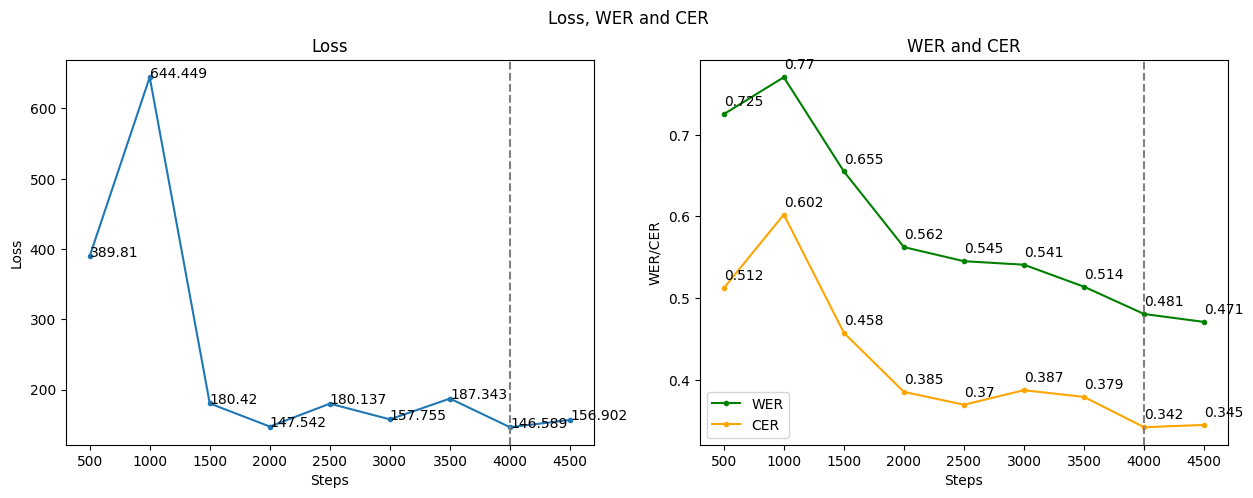

In [98]:
#plot loss on left, wer and cer on right, x axis is steps
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle('Loss, WER and CER')
ax1.plot(step, eval_loss, marker='.')
ax1.axvline(x=4000, color='gray', linestyle='--')
#show the values of each marking
for i, j in zip(step, eval_loss):
    ax1.annotate(str(round(j, 3)), xy=(i, j - 0.01))
ax1.set_title('Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax2.plot(step, eval_wer, label="WER", marker='.', color='green')
ax2.plot(step, eval_cer, label="CER", marker='.', color = 'orange')
#show the values of each marking
for i, j in zip(step, eval_wer):
    ax2.annotate(str(round(j, 3)), xy=(i, j + 0.01))
for i, j in zip(step, eval_cer):
    #show the annotation a little bit more sepatated from the line
    ax2.annotate(str(round(j, 3)), xy=(i, j+0.01))

ax2.set_title('WER and CER')
ax2.set_xlabel('Steps')
ax2.set_ylabel('WER/CER')
ax2.legend()
ax2.axvline(x=4000, color='gray', linestyle='--')
plt.show()

### Results on our previous model

In [99]:
with open('./results/checkpoint-3000/trainer_state.json') as json_file:
    data = json.load(json_file)

epoch = []
eval_loss = []
eval_wer = []
step = []
for element in data['log_history']:
    if len(element) < 5:continue
    else:
        epoch.append(element['epoch'])
        eval_loss.append(element['eval_loss'])
        eval_wer.append(element['eval_WER'])
        step.append(element['step'])

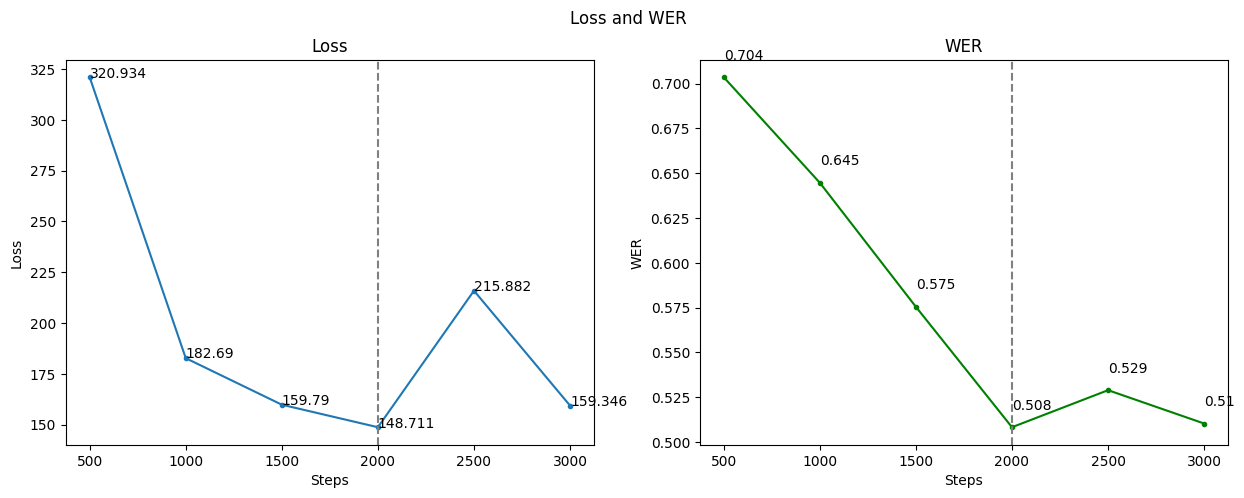

In [100]:
#plot loss on left and wer on right, x axis is steps
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
fig.suptitle('Loss and WER')
ax1.plot(step, eval_loss, marker='.')
ax1.axvline(x=2000, color='gray', linestyle='--')
#show the values of each marking
for i, j in zip(step, eval_loss):
    ax1.annotate(str(round(j, 3)), xy=(i, j - 0.01))
ax1.set_title('Loss')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')
ax2.plot(step, eval_wer, marker='.', color='green')
#show the values of each marking
for i, j in zip(step, eval_wer):
    ax2.annotate(str(round(j, 3)), xy=(i, j + 0.01))
ax2.set_title('WER')
ax2.set_xlabel('Steps')
ax2.set_ylabel('WER')
ax2.axvline(x=2000, color='gray', linestyle='--')
plt.show()